# Practical tips for class imbalance

### Class imbalance

Class imbalance: the classes are not represented equally in a classification problem

Class imbalance is common in:
        + Fraud detection
        + Rare adverse drug reactions
        + Predict gene families (e.g. Kinase, GPCR)


In [1]:
% matplotlib inline
from collections import OrderedDict
from utils import *

First, we load the data set and plot the points on a 2-dimensional grid (note the imbalance of course)!

(2503, 53) (2503,)
positive class ratio 0.019576508190171794


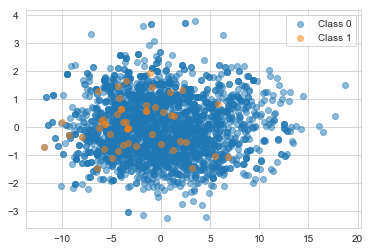

In [2]:
# Load the data
X, y = load_proteomics()

print(X.shape, y.shape)
print('positive class ratio', y.sum()/float(y.shape[0]))
fig = pca_plot(X, y)

## 1. Stratification matters!

A first tactic we can use is stratification when we are applying cross validation: allocate the samples evenly based on sample classes so that the training and test set have a similiar ratio of classes.

In [3]:
from sklearn.cross_validation import KFold, StratifiedKFold, cross_val_score

n_folds = 3

### IMPLEMENT THE KFOLD (cv) VS STRATIFIEDKFOLD (scv) 
cv = KFold(len(y), n_folds=3)
scv = StratifiedKFold(y, n_folds=3)

# Examine the positive labels in train and test folds
print('KFold not Stratified')
for train_idx, test_idx in cv:
    print(y[train_idx].sum(), y[test_idx].sum())

print('StratifiedKFold')
for train_idx, test_idx in scv:
    print(y[train_idx].sum(), y[test_idx].sum())


KFold not Stratified
29 20
30 19
39 10
StratifiedKFold
32 17
33 16
33 16


/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=5, random_state=RNG)
for metric in ['f1', 'roc_auc', 'average_precision', 'accuracy', 'precision', 'recall']:
    score1 = cross_val_score(clf, X, y, metric, cv=cv).mean()
    score2 = cross_val_score(clf, X, y, metric, cv=scv).mean()
    print('%s, CV: %.6f, stratified CV: %.6f' % (metric, score1, score2))
        

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


f1, CV: 0.030303, stratified CV: 0.130096
roc_auc, CV: 0.663700, stratified CV: 0.690837
average_precision, CV: 0.062047, stratified CV: 0.141473
accuracy, CV: 0.980026, stratified CV: 0.979226


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


precision, CV: 0.111111, stratified CV: 0.388889
recall, CV: 0.017544, stratified CV: 0.080882


With such an easy tactic we already see a significant improve, now we are going to look at different metrics.

## 2. Performance metrics for binary classification

+ ### Accuracy is misleading
![Accuracy](https://upload.wikimedia.org/math/8/c/3/8c3f5b1cef3a52644de5056fd2fafee6.png)
+ ### Confusion matrix helps break down the predictive performance to different classes
![Confusion matrix](http://www.dataschool.io/content/images/2015/01/confusion_matrix2.png)
+ ### Bipartition based metrics (Precision, Recall, F1-score) differs depending on the positive class
Precision or positive predictive value (PPV) 
![Precision](https://upload.wikimedia.org/math/6/b/5/6b55614c9bcfa7596145265be222c4c9.png)
Recall or true positive rate (TPR) or sensitivity 
![Recall](https://upload.wikimedia.org/math/8/b/f/8bf211db6603570bbb1926f911097b18.png)
F1-score (harmonic mean of Precision and Recall) 
![F1-score](https://upload.wikimedia.org/math/9/9/1/991d55cc29b4867c88c6c22d438265f9.png)

### Confusion Matrix
First plot the confusion matrix and observe what is going on (tip: check *classification_report* of sklearn for better viewability)

In [5]:
from sklearn import metrics

# Use these indices for training/test set
train_idx, test_idx = list(scv)[0]

### IMPLEMENT RANDOM FOREST AND GET CONFUSION MATRIX
clf = RandomForestClassifier(n_estimators=10, random_state=RNG)

clf.fit(X[train_idx], y[train_idx])
print(X[train_idx].shape, X[test_idx].shape)
y_probas = clf.predict_proba(X[test_idx])[:,1]
y_preds = clf.predict(X[test_idx])

# Confusion matrix
print('--confusion matrix--')
cm = metrics.confusion_matrix(y[test_idx], y_preds, labels=[0,1])
print(cm)
print('--classification report --')
print(metrics.classification_report(y[test_idx], y_preds, labels=[0,1]))

(1668, 53) (835, 53)
--confusion matrix--
[[814   4]
 [ 15   2]]
--classification report --
             precision    recall  f1-score   support

          0       0.98      1.00      0.99       818
          1       0.33      0.12      0.17        17

avg / total       0.97      0.98      0.97       835



Now you are going to implement and plot the ROC curve, luckily (as always) sklearn has an easy option for this!

AUROC = 0.793147
Accuracy  0.9772455089820359


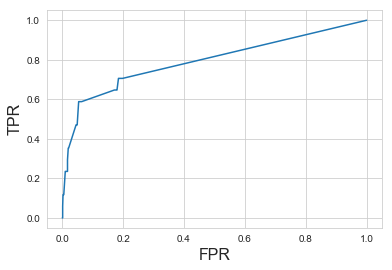

In [6]:
# Plot ROC curve

### CREATE AND PLOT ROC CURVE
fig, ax = plt.subplots()

fpr, tpr, thresholds = metrics.roc_curve(y[test_idx], y_probas)
ax.plot(fpr, tpr, color=COLORS10[0])

ax.legend(loc='best')
ax.set_xlabel('FPR', fontsize=16)
ax.set_ylabel('TPR', fontsize=16)
print('AUROC = %.6f' % metrics.auc(fpr, tpr))
print('Accuracy ', metrics.accuracy_score(y[test_idx], y_preds))

## Resampling to get more balanced data
We will implement two simple resampling techniques, first one is down sampling and the second one is up sampling.

![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/resampling.png)

We will now see the difference in the distributions when we use the different samplers. You need to implement the under and over samplers using the imblearn package.

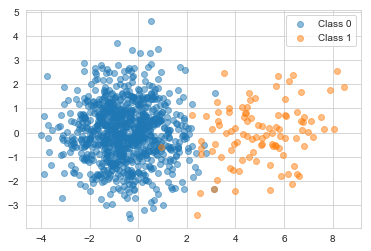

In [7]:
# Demo the effect of resampling
# Load synthetic data
X, y = load_synthetic_data()
# Original
fig = pca_plot(X, y)

(200, 50) (1000, 50)


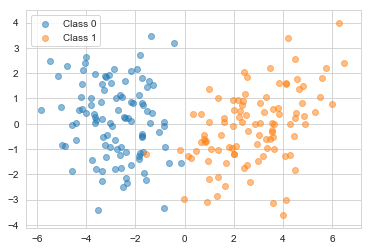

In [8]:
from imblearn.under_sampling import RandomUnderSampler
# Down-sampling
### IMPLEMENT UNDERSAMPLER AND PLOT PCA
us = RandomUnderSampler()
X_dn, y_dn = us.fit_sample(X, y)
fig = pca_plot(X_dn, y_dn)
print(X_dn.shape, X.shape)

(1800, 50) (1000, 50)


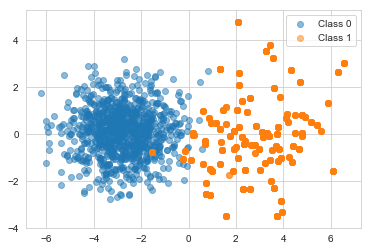

In [9]:
from imblearn.over_sampling import RandomOverSampler
# Over-sampling
### IMPLEMENT OVERRSAMPLER AND PLOT PCA
os = RandomOverSampler()
X_up, y_up = os.fit_sample(X, y)
fig = pca_plot(X_up, y_up)
print(X_up.shape, X.shape)

Now we can implement Random Forests with either no sampling, up sampling and down sampling to observe the difference in performance.

For this part you need to implement either the up sampling and down sampling tree (check the definition of *ResampleForestClassifier* in *resample_forest.py* for valid options).

In [10]:
from sklearn.base import clone
from resample_forest import ResampleForestClassifier

tree = DecisionTreeClassifier()

rf = ResampleForestClassifier(tree, n_estimators=10, sampling=None, random_state=RNG, verbose=False)

### IMPLEMENT UPSAMPLED RF (rf_up)
rf_up = ResampleForestClassifier(tree, n_estimators=10, sampling='up', random_state=RNG, verbose=False)

### IMPLEMENT DOWNSAMPLED RF (rf_dn)
rf_dn = ResampleForestClassifier(tree, n_estimators=10, sampling='down', random_state=RNG, verbose=False)

clfs = [rf, rf_up, rf_dn]

After creating multiple Random Forests we can create boxplots to see the difference in the AUROC corresponding to different folds of the cross-validation.

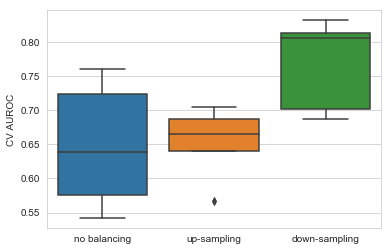

In [11]:
X, y = load_proteomics()
cv = StratifiedKFold(y, n_folds=5)
labels = ['no balancing', 'up-sampling', 'down-sampling']
clfs = [rf, rf_up, rf_dn]

aurocs = OrderedDict()
for i in range(len(clfs)):
    clf = clfs[i]
    aurocs[labels[i]] = cross_val_score(clf, X, y, 'roc_auc', cv=cv)

aurocs = pd.DataFrame(aurocs)
    
fig, ax = plt.subplots()

sns.boxplot(data=aurocs, ax=ax)
ax.set_ylabel('CV AUROC')
plt.show()

Interestingly, up-sampling is not improving the model score, can you think of any reasons why?

We will now show why this is the case.

In [12]:
# Get the training and test performance
train_scores = np.zeros((3, len(cv)))
test_scores = np.zeros((3, len(cv)))

for i, clf in enumerate([rf, rf_up, rf_dn]):
    for j, (train_idx, test_idx) in enumerate(cv):
        clf = clone(clf) 
        clf.fit(X[train_idx], y[train_idx])
        y_probas = clf.predict_proba(X)[:, 1]
        
        train_auc = metrics.roc_auc_score(y[train_idx], y_probas[train_idx])
        test_auc = metrics.roc_auc_score(y[test_idx], y_probas[test_idx])
        
        train_scores[i, j] = train_auc
        test_scores[i, j] = test_auc
        
x = range(3)
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)

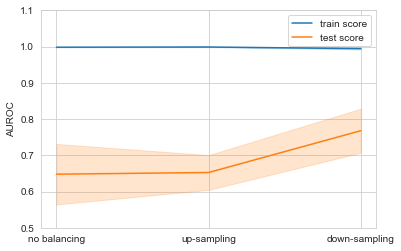

In [13]:
# Plot the difference between training and test performance
fig, ax = plt.subplots()
ax.plot(x, train_mean, label='train score', color=COLORS10[0])
ax.fill_between(x,  train_mean-train_std, train_mean+train_std, color=COLORS10[0], alpha=0.2)
ax.plot(x, test_mean, label='test score', color=COLORS10[1])
ax.fill_between(x,  test_mean-test_std, test_mean+test_std, color=COLORS10[1], alpha=0.2)
ax.legend(loc='best')
ax.set_ylabel('AUROC')
ax.set_ylim([0.5,1.1])
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.show()

Seeing the above graph, when is it not a good idea to use up-sampling?

## SVM
At last, we will show how a weighted loss function can change the classification performance. Easy interpretation is that errors in the under minority class will be weighted higher than their counterparts to combat the imbalance in the errors. So imagine the regular binary cross entropy function:

$$ \mathcal{L} = - y\log \hat{y} - (1-y) \log (1-\hat{y})$$

Easy way to tweak this is putting a coefficient in front of the error of one class, ie:

$$ \mathcal{L} = - y\log \hat{y} - \beta(1-y) \log (1-\hat{y})$$

We will use an SVM for this, do not forget to set the kernel to 'linear'!

(-5.5, 5.5, -5.3785077290481835, 8.996466415341494)

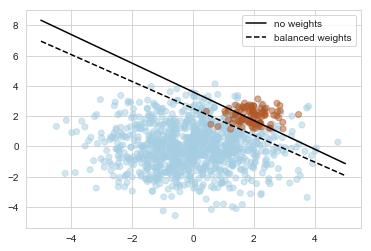

In [14]:
from sklearn.svm import SVC

# Create 40 separable points
rng = np.random.RandomState(0)
n_samples_1 = 1000
n_samples_2 = 100
X = np.r_[1.5 * rng.randn(n_samples_1, 2),
          0.5 * rng.randn(n_samples_2, 2) + [2, 2]]
y = [0] * (n_samples_1) + [1] * (n_samples_2)


### CREATE REGULAR SVM MODEL HERE
clf = SVC(kernel='linear')
clf.fit(X, y)

# Get the separating hyperplane of unbalanced SVM
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5, 5)
yy = a * xx - clf.intercept_[0] / w[1]


### CREATE BALANCED SVM HERE
wclf = SVC(kernel='linear', class_weight='balanced')
wclf.fit(X, y)

# Get the separating hyperplane of balanced SVM
ww = wclf.coef_[0]
wa = -ww[0] / ww[1]
wyy = wa * xx - wclf.intercept_[0] / ww[1]

# Plot hyperplanes and samples
h0 = plt.plot(xx, yy, 'k-', label='no weights')
h1 = plt.plot(xx, wyy, 'k--', label='balanced weights')
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, alpha=0.5)
plt.legend()

plt.axis('tight')
